In [2]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold._t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

In [4]:
X, y = load_digits(return_X_y=True)

In [6]:
MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30

In [7]:
def fit(X):
    n_samples = X.shape[0]
    
    # Compute euclidean distance
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    # Compute joint probabilities p_ij from distances.
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    
    # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
    # degrees_of_freedom = n_components - 1 comes from
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

In [10]:
def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
    params = X_embedded.ravel()
    
    obj_func = _kl_divergence
    
    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
        
    X_embedded = params.reshape(n_samples, n_components)
    return X_embedded

In [12]:
x = np.array([[1, 2, 3], [4, 5, 6]])
np.ravel(x)

array([1, 2, 3, 4, 5, 6])

In [13]:
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
    # Kullback-Leibler divergence of P and Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    # Gradient: dC/dY
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    return kl_divergence, grad

In [14]:
def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        error, grad = obj_func(p, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      % (i + 1, error, grad_norm))
        
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break
    return p

In [ ]:
X_embedded = fit(X)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

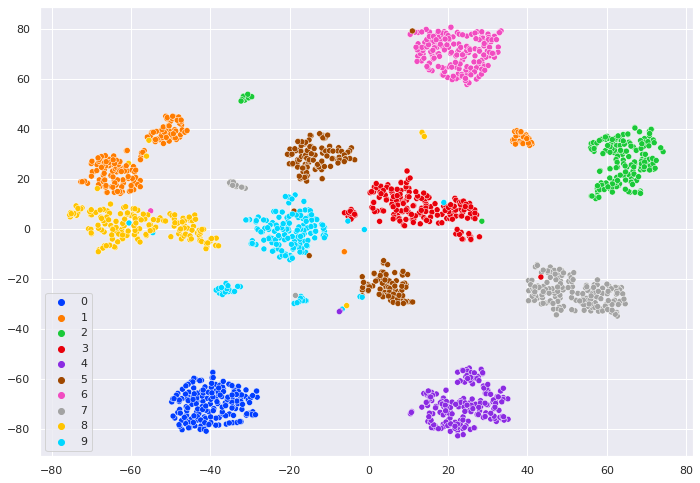

In [16]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

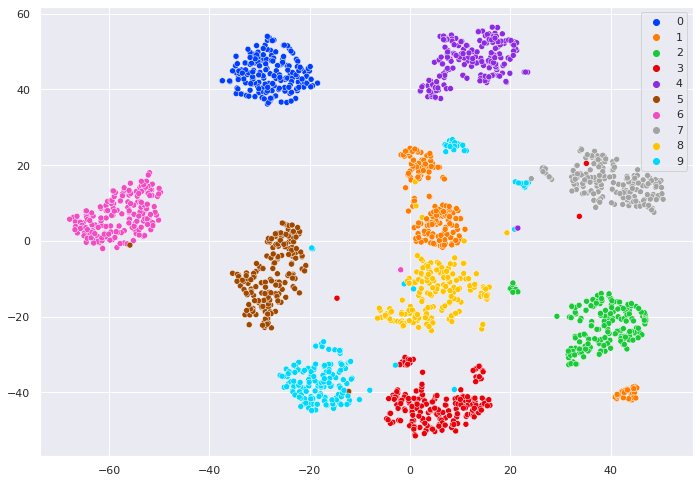

In [17]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

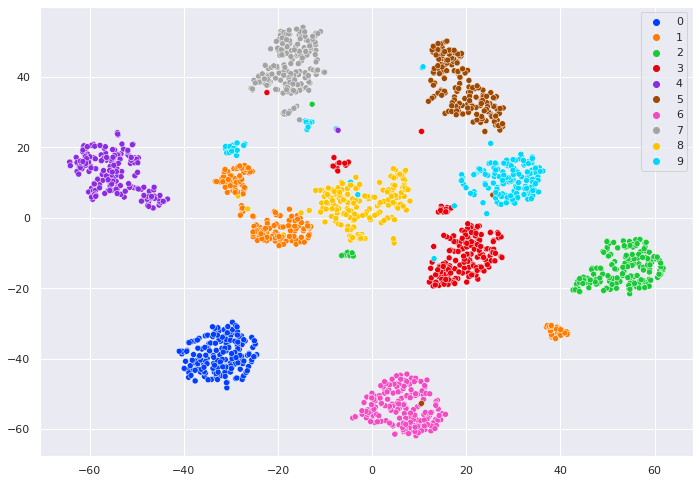

In [21]:
tsne = TSNE(n_components=2, perplexity=30.0)
X_embedded = tsne.fit_transform(X)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

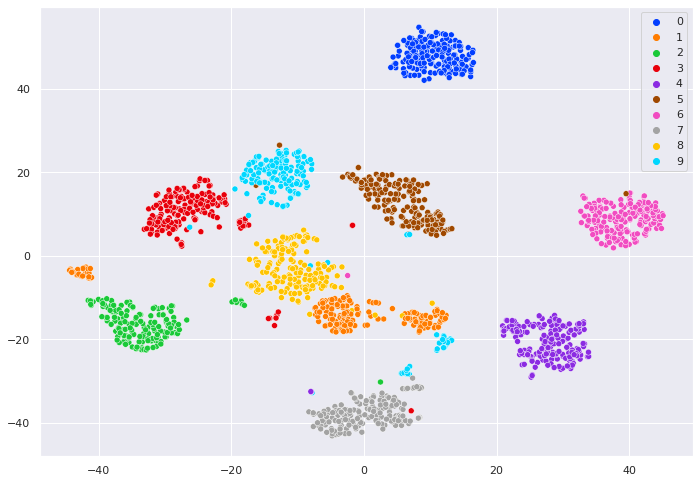

In [22]:
tsne = TSNE(n_components=2, perplexity=50.0)
X_embedded = tsne.fit_transform(X)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

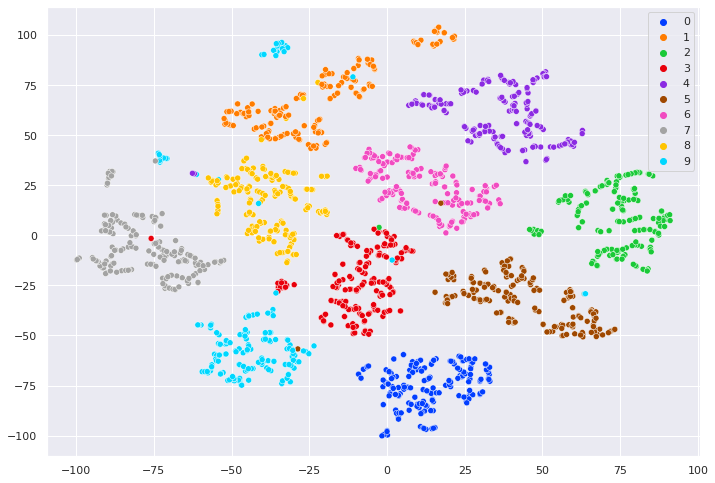

In [23]:
tsne = TSNE(n_components=2, perplexity=5)
X_embedded = tsne.fit_transform(X)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

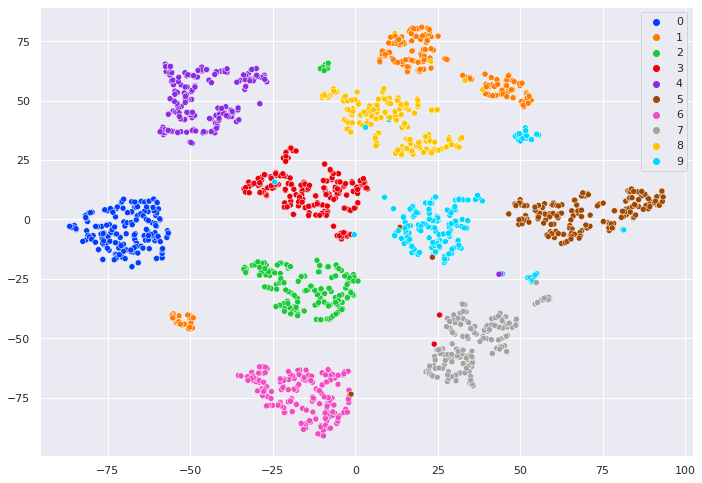

In [24]:
tsne = TSNE(n_components=2, perplexity=10)
X_embedded = tsne.fit_transform(X)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

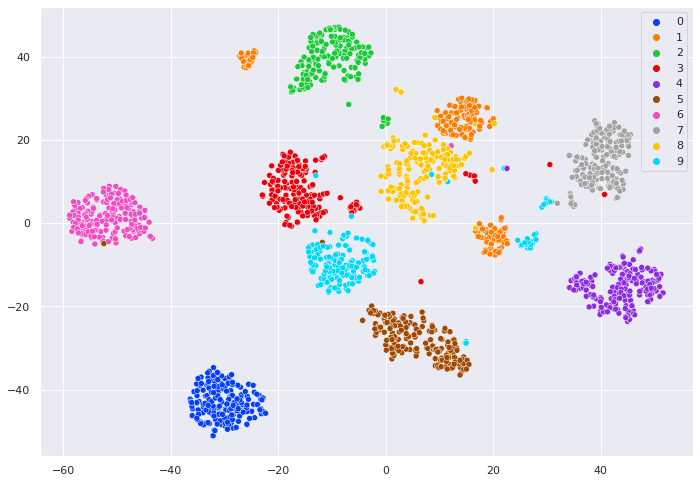

In [25]:
tsne = TSNE(n_components=2, perplexity=40)
X_embedded = tsne.fit_transform(X)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)